# A Semi-automated Delta Method and Saturated Dissolved Oxygen Model

In this notebook, I have created a semi-automated application of the Delta Method from Capara and DiToro (1993). Additionally, I have created a saturated dissolved oxygen model based on the equations presented in Lecture 19 of Chapra (2008). To demonstrate the application of these models, I will explore the primary production, respiration, and dissolved oxygen for Stroubles Creek in Blacksburg, Virginia.

Author: Billy Raseman, Graduate Research Assistant at University of Colorado Boulder

## Delta Method assumptions

## Water quality data

Data is provided by the Learning Enhanced Watershed Assessment System (LEWAS) Laboratory run by Dr. Vinod Lohani and Dr. Randel Dymond (pictured below).

"LEWAS is a real-time water and weather monitoring system developed to enhance water sustainability eduacation and research at Virginia Tech... [it] has sensors to measure water quality and quantity data including flow rate, depth, pH, dissolved oxygen, conductivity, and temperature." (http://www.lewas.centers.vt.edu/) See figure below for more details. 

In [170]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://www.lewas.centers.vt.edu/images/FlowDiagramWIPv2presentations-02.jpg")

## Define saturated dissolved oxygen (DO) Model

In [166]:
def sat_dissolved_oxygen(temp_C, salinity, elev=None, pressure=None):

    """
    -------------------------------------------------------------------------------
    Purpose: Calculate the saturation dissolved oxygen (DO) for a given temperature, 
             salinity, and elevation (or pressure) 
    Source: Chapra, S.C., 2008. Surface water-quality modeling. Waveland press.
            (all equations references are from Chapra, 2008)
    -------------------------------------------------------------------------------
    
    Input: 
        temp_C   - temperature of water in degrees Celcius       
        salinity - salinity of water in parts per thousand (ppt) 
        pressure - atmospheric pressure (atm)          [no input if elev is specified]           
        elev     - elevation above sea level (in km)   [no input if pressure is specified]     
            
    Output
        o_sat   - saturated dissolved oxygen for given input parameters (mg/L)
             
    Author: Billy Raseman
    
    """      
    
    # Convert Celcius to Kelvin
    temp_abs = temp_C + 273.15
    
    # Temperature Effect: eq 19.32
    o_sf = np.exp(-139.34411 + 1.575701e5/temp_abs - 6.642308e7/temp_abs**2 + 
               1.243800e10/temp_abs**3 - 8.621949e11/temp_abs**4)  
        # saturation conc. of dissolved oxygen (DO) in fresh water at 1 atm (mg/L)

    # Salinity Effect: eq 19.34
    o_ss = np.exp( np.log(o_sf) - salinity*(1.7674e-2 - 1.0754e1/temp_abs + 2.1407e3/temp_abs**2) )  
        # saturation conc. of DO at 1 atm accounting for any salinity (mg/L)
        # Note: if unsalinated, o_sf = o_ss

    # Pressure Effect: eq 19.39
    ## If there is no input for elevation, use pressure to calculate sat. DO
    if elev is None:
         
        ## If there is also no input for pressure, error out of function
        if pressure is None: 
            print("Error: input for either pressure or elevation is required.")
            return
        
        else:
            ## Using pressure input
            theta = 0.000975 - 1.426e-5*temp_C + 6.436e-8*temp_C**2  # fitting parameter, eq 19.38 
            pressure_wv = np.exp(11.8571 - 3840.70/temp_abs - 216961/temp_abs**2) 
                # partial pressure of water vapor (atm), eq 19.37
            o_sp = o_ss*pressure*( ((1-pressure_wv/pressure)*(1-theta*pressure)) / ((1-pressure_wv)*(1-theta)) )
                # saturation conc. of DO in water at input pressure (mg/L), eq 19.36
    
    ## For the case that there is an input for elevation
    else: 
        
        ## Using elevation input   
        o_sp = o_ss*(1 - 0.1148*elev)  
        # saturation conc. of DO in water at pressure p (or elevation elev) (mg/L)
        # Note: if at sea level, o_ss = o_sp     
        
        if pressure is not None:
            print("Ignoring pressure input, and using elevation input instead.")
            print("To use pressure calculation, delete elevation argument.")
    
    o_sat = o_sp  # these are equivalent, but o_sat is better naming convention (mg/L)
    
    return o_sat

# Example: Stroubles Creek in Blacksburg, VA

## Import packages

In [134]:
import numpy as np     # fundamental scientific computing package
import pandas as pd    # data structures and data analysis tools 
import matplotlib.pyplot as plt  # 2D plotting library (MATLAB-like plotting framework)
import matplotlib.dates as mdates  # plot date formatting
import datetime as dt  # for manipulating date and time data 
%matplotlib inline

## Import temperature data

In [135]:
df_wq = pd.read_csv("lewas_data-WQ_2014-05.csv")  # water quality data from May 2014
df_wq['Time'] = pd.to_datetime(df_wq['Time'], format='%I:%M:%S %p').dt.time  # convert to class datetime
df_wq['Date'] = pd.to_datetime(df_wq['Date']).dt.date  # convert to class datetime
for i in range(0, len(df_wq)): 
    df_wq.loc[i, 'Datetime']= dt.datetime.combine(df_wq['Date'][i], df_wq['Time'][i])
df_wq.head()  # visualize beginning of dataset

,Date,Time,Temp [deg C],pH [Units],DO [mg/l],TurbSC [NTU],TDS [g/l],Datetime
0,2014-05-01,00:04:40,13.50,8.04,7.83,3.0,0.5,2014-05-01 00:04:40
1,2014-05-01,00:09:40,13.50,8.03,7.84,2.9,0.4,2014-05-01 00:09:40
2,2014-05-01,00:14:40,13.49,8.03,7.77,3.0,0.4,2014-05-01 00:14:40
3,2014-05-01,00:19:40,13.49,8.02,7.75,3.4,0.4,2014-05-01 00:19:40
4,2014-05-01,00:24:40,13.48,8.03,7.74,3.0,0.4,2014-05-01 00:24:40


## Calculated saturated dissolved oxygen concentration

In [137]:
df_wq['Saturated DO [mg/l]'] = "" # initialize empty array for 'for-loop'

In [138]:
# calculate saturated DO
df_wq['Saturated DO [mg/l]'] = "" # initialize empty array for 'for-loop'
salinity = 0  # assume no salinity in river
elev = 0.634  # elevation of Blacksburg, VA (km)

for i in range(0, len(df_wq)): 
    df_wq.loc[i, 'Saturated DO [mg/l]'] = sat_dissolved_oxygen(df_wq.loc[i, 'Temp [deg C]'], salinity, elev)
    # for info on .loc, see: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy 

### Plot calculated saturated DO and observed DO for May 2014 

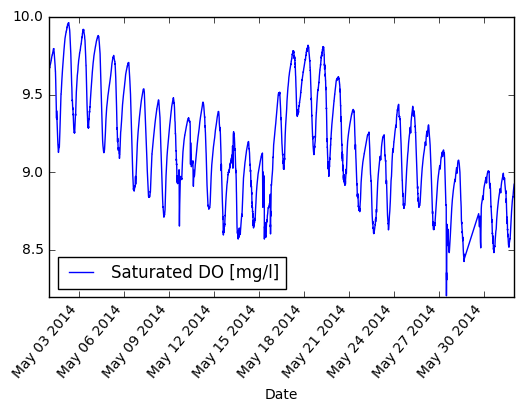

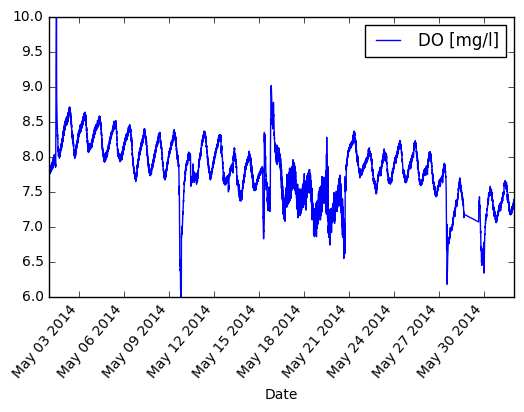

In [149]:
df_wq.plot(x='Datetime', y='Saturated DO [mg/l]')  # plot
plt.xticks(rotation=50)
plt.xlabel('Date')
df_wq.plot(x='Datetime', y='DO [mg/l]')  # plot
plt.ylim(6, 10)  # zoom into DO plot
plt.xticks(rotation=50)
plt.xlabel('Date')

### Plot calculated saturated DO and observed DO for May 2, 2014

In [157]:
df_may2 = df_wq[(df_wq['Date'] > dt.date(2014, 5, 1)) & (df_wq['Date'] < dt.date(2014, 5, 3))]
df_may2.head()

,Date,Time,Temp [deg C],pH [Units],DO [mg/l],TurbSC [NTU],TDS [g/l],Datetime,Saturated DO [mg/l]
272,2014-05-02,00:00:20,12.86,8.09,8.37,1.7,0.5,2014-05-02 00:00:20,9.80044
273,2014-05-02,00:05:20,12.85,8.09,8.36,1.5,0.5,2014-05-02 00:05:20,9.80263
274,2014-05-02,00:10:20,12.82,8.09,8.38,1.2,0.5,2014-05-02 00:10:20,9.80923
275,2014-05-02,00:15:20,12.81,8.09,8.44,0.9,0.5,2014-05-02 00:15:20,9.81143
276,2014-05-02,00:20:20,12.79,8.09,8.44,0.8,0.5,2014-05-02 00:20:20,9.81583


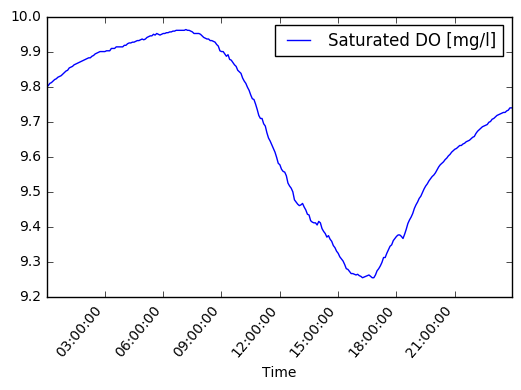

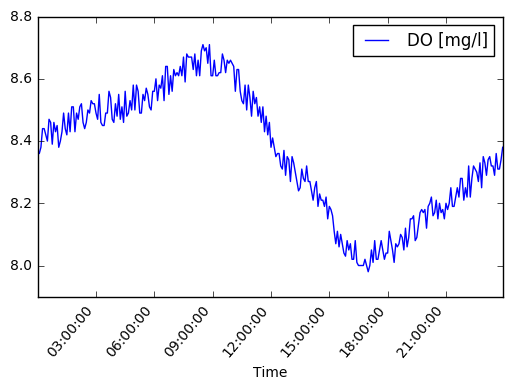

In [160]:
df_may2.plot(x='Datetime', y='Saturated DO [mg/l]')  # plot
plt.xticks(rotation=50)
plt.xlabel('Time')
df_may2.plot(x='Datetime', y='DO [mg/l]')  # plot
plt.xticks(rotation=50)
plt.xlabel('Time')

In [165]:
avg_temp_C = 13.45  # degrees Celcius
salinity = 0  # assume no salinity in river
elev = 0.626  # elevation of LEWAS station (km), source: http://www.lewas.centers.vt.edu/dataviewer/data_corrections.html

o_sat_avg = sat_dissolved_oxygen(avg_temp_C, salinity, elev)
print("Average Saturated DO concentration:", round(o_sat_avg, 2), "mg/L")

Average Saturated DO concentration: 9.68 mg/L
